W projekcie powinny znaleźć się następujące elementy:

- wstęp zawierający cel pracy,
- opis i wstępna analiza wykorzystywanych danych (źródło danych, podstawowe statystyki, wykresy, współczynniki zmienności, korelacje, wartości odstające itp.),
- zastosowanie minimum dwóch technik porządkowania liniowego (wzorcową i bezwzorcową),
- zastosowanie minimum dwóch technik analizy skupień (grupowanie podziałowe i hierarchiczne), w tym uzasadnienie wyboru wybranej liczby skupień,
- interpretacja uzyskanych wyników:
  - porządkowanie liniowe: ocena rankingów, podobieństwo wyników (korelacja), grupowanie wg średniej itd.,
  - analiza skupień: interpretacja poszczególnych klastrów, porównanie wyników grupowania wykonanego różnymi metodami,
- podsumowanie.

Sprawozdanie z projektu powinno skupiać się przede wszystkim na analizie danych i wyników,  a w mniejszym stopniu na sposobie implementacji poszczególnych metod.

W projekcie wykorzystuję swój własny zbiór, stworzony na podstawie cen kryptowaluty Bitcoin (open, high, low, close, volume).

Zbiór danych zawiera takie cechy jak:

| Cecha                  | Skrót              | Jednostka | Opis                                     |
| ---------------------- | ------------------ | --------- | ---------------------------------------- |
| Średni zasięg świecy   | `range_mean`       | USD       | zmienność surowa                         |
| Średni wolumen         | `volume_mean`      | BTC       | aktywność rynku                          |
| ATR (30min)            | `atr_mean`         | USD       | wygładzona zmienność                     |
| Średnia % zmiana ceny  | `return_mean`      | %         | kierunek i dynamika                      |
| Odchylenie std % zmian | `return_std`       | %         | zmienność zwrotów                        |
| Asymetria zwrotów      | `skewness`         | bezj.     | kierunkowa przewaga (bycza/niedźwiedzia) |
| Spiczastość zwrotów    | `kurtosis`         | bezj.     | występowanie ekstremów                   |
| Sharpe ratio           | `sharpe`           | bezj.     | relacja zysk–ryzyko                      |


| Cecha                  | Skrót              | Jednostka | Opis                                     |
| ---------------------- | ------------------ | --------- | ---------------------------------------- |
| Ile zajmuje knot       | `wick_ratio`       | 0-1       | Czy ruch był szaroany                    |
| Ile zajmuje body       | `body_ratio`  	  | 0-1       | Czy ruch był płynny                      |
| Stabilość trendu       | `trend_stability`  | 0-1       | Czy trend stabliny / szaroany            |
| Zmienność Wewnętrzna   | `micro_vol`  	  | 0-1       | mikro-zmienność wewnętrzna            	 |

# 1. Przygtowanie danych

Z racji iż zbiór oraz cechy wymyśiłem sam to też sam musiałem je wyliczyć, poniższe kilka bloków należy do podstawowego wyliczania danych.

In [174]:
import pandas as pd
from ta.volatility import AverageTrueRange
from sklearn.preprocessing import StandardScaler

In [175]:
df = pd.read_csv('BTCUSDT_1m.csv')

In [176]:
# Upewniam się, że pole daty ma typ daty
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.sort_values('datetime')

# Ustawiam datę jako indeks
df = df.set_index('datetime')

print(df.head())

                      timestamp      open      high       low     close  \
datetime                                                                  
2024-12-31 23:00:00  1735686000  93488.83  93488.84  93445.45  93445.45   
2024-12-31 23:01:00  1735686060  93445.46  93480.50  93405.27  93417.72   
2024-12-31 23:02:00  1735686120  93417.71  93475.45  93417.71  93475.45   
2024-12-31 23:03:00  1735686180  93475.45  93569.44  93475.45  93507.66   
2024-12-31 23:04:00  1735686240  93507.66  93535.02  93388.81  93417.68   

                       volume  
datetime                       
2024-12-31 23:00:00   8.37480  
2024-12-31 23:01:00  13.65448  
2024-12-31 23:02:00   3.38207  
2024-12-31 23:03:00   8.35472  
2024-12-31 23:04:00  19.76090  


In [177]:
# Agreaguję dane do 30-minutowych świec
df_30m = df.resample('30min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

In [178]:
# Zasięg świecy
df_30m['range'] = df_30m['high'] - df_30m['low']

# Zwrot procentowy
df_30m['return'] = (df_30m['close'] - df_30m['open']) / df_30m['open'] * 100

atr_indicator = AverageTrueRange(df_30m['high'], df_30m['low'], df_30m['close'], window=14)
df_30m['ATR'] = atr_indicator.average_true_range()

# Żeby trzymać info o wszytskich zwrotach 
df_30m['is_positive'] = df_30m['return'] > 0

In [179]:
# Tworzę etykiety, po to by móc potem pogrupować dane po każdej pólgodzinie

# Godzina i półgodzina
df_30m['hour'] = df_30m.index.hour
df_30m['minute'] = df_30m.index.minute

# Nazwa przedziału (np. "13:00-13:30")
df_30m['interval'] = df_30m['hour'].astype(str).str.zfill(2) + ':' + df_30m['minute'].astype(str).str.zfill(2)

# print(df_30m.tail(30))


In [180]:
# Grupuję po półgodzinie, którą powyżej zdefiniowałem
grouped = df_30m.groupby('interval')

# Agregacja miar
stats = grouped.agg(
    range_mean=('range', 'mean'),
    volume_mean=('volume', 'mean'),
    atr_mean=('ATR', 'mean'),
    return_mean=('return', 'mean'),
    return_std=('return', 'std'),
    pos_count=('is_positive', 'sum'),
    count=('is_positive', 'count'),
    skewness=('return', pd.Series.skew),
    kurtosis=('return', pd.Series.kurtosis)
)

# Sharpe ratio
stats['sharpe'] = stats['return_mean'] / stats['return_std']

# Liczba dni z dodatnim wynikiem (%)
stats['pos_ratio'] = stats['pos_count'] / stats['count'] * 100


In [181]:
print(stats.head(48))
# stats.to_csv('btc_30m_stats.csv', index=True)

          range_mean  volume_mean    atr_mean  return_mean  return_std  \
interval                                                                 
00:00     443.155404   453.288487  439.317716    -0.021828    0.342737   
00:30     441.916561   409.842869  439.316009    -0.015770    0.304417   
01:00     444.037263   404.903983  439.505600    -0.011151    0.343501   
01:30     442.851684   439.359939  439.641712     0.001679    0.401351   
02:00     427.447930   405.261966  438.717948     0.020526    0.283952   
02:30     384.737088   395.498296  434.771367    -0.004216    0.271403   
03:00     360.418982   357.037946  429.377240    -0.000010    0.254004   
03:30     311.572526   330.170267  420.921785    -0.005945    0.228253   
04:00     319.927123   313.531025  413.668041     0.014175    0.208746   
04:30     319.142281   316.730416  406.856542     0.015871    0.237203   
05:00     311.905965   323.462772  399.977641     0.005250    0.231295   
05:30     286.804737   302.461444  393

# Porządkowanie Liniowe

## Metoda bezwzorcowa

Jako metodę bezwzorcową wybrałem **metodę porządkowania liniowego**.
W celu stworzenia rankingu rozpocząłem od odpowiedniego dostosowania danych.

Celem przygotowanego rankingu jest określenie, **które godziny są najbardziej aktywne** (pod względem zwrotu i wolumenu) oraz **najbardziej kierunkowe** (czyli wykazujące wyraźne wzrosty lub spadki).

Do przeprowadzenia rankingu wybrałem podzbiór zmiennych, które – z logicznego punktu widzenia – najlepiej opisują to zjawisko:

| Zmienna       | Typ          | Co mierzy            |
| ------------- | ------------ | -------------------- |
| `range_mean`  | stymulanta   | zmienność surowa     |
| `volume_mean` | stymulanta   | aktywność rynku      |
| `atr_mean`    | stymulanta   | wygładzona zmienność |
| `abs_sharpe`  | stymulanta   | kierunkowość ruchu   |
| `return_std`  | destymulanta | chaos / losowość     |

Jak można zauważyć, pojawiła się nowa zmienna `abs_sharpe`.
Jak sama nazwa wskazuje, jest to po prostu współczynnik Sharpe’a, dla którego zastosowano wartość bezwzględną.
Nie można uznać tej zmiennej za **nominantę**, ponieważ w jej przypadku pożądane są wartości **jak najbardziej oddalone od zera**.
Oznacza to, że optimum nie jest pojedyncze, lecz **podwójne** – może nim być zarówno **wysokie odchylenie ujemne**, jak i **wysokie odchylenie dodatnie**.
Z tego względu logiczne jest zastosowanie wartości bezwzględnej, aby uchwycić siłę kierunkowości niezależnie od jej znaku.

Także `return_std` zostało uznanę za destymuantę, ponieważ chcemy by nasze zwroty były bardziej stabilne i przewidywalne niż 'rozrzucone'.

In [182]:
# Dodaję nową kolumnę abs_sharpe
stats['abs_sharpe'] = stats['sharpe'].abs()

# Zmieniam destymuklantę na stymulantę
stats['return_std_stim'] = -stats['return_std']

# WYbieram cechy jakie chce uwzględnić przy towrzeniu tego rankingu
features = ['range_mean', 'volume_mean', 'atr_mean', 'abs_sharpe', 'return_std_stim']

# Standaryzacja
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(stats[features]),
    columns=features,
    index=stats.index
)

X_scaled.head()

,range_mean,volume_mean,atr_mean,abs_sharpe,return_std_stim
interval,,,,,
00:00,0.242293,0.096020,0.557834,0.428301,-0.244532
00:30,0.230333,-0.210685,0.557790,0.130102,0.174726
01:00,0.250806,-0.245552,0.562613,-0.355268,-0.252883
01:30,0.239361,-0.002309,0.566075,-1.064973,-0.885820
02:00,0.090656,-0.243024,0.542577,0.644145,0.398630


In [183]:
# Obliczam wynik sumaryczny (prosty ranking bezwzorcowy)
stats['score_simple'] = X_scaled.sum(axis=1)

ranking = stats[['score_simple']].sort_values(by='score_simple', ascending=False)

print(ranking.head(10))

          score_simple
interval              
15:00         3.650088
17:00         3.420567
13:30         3.053776
20:00         2.588763
19:00         2.477828
15:30         2.454647
14:30         2.439673
16:30         2.336674
23:00         1.923677
16:00         1.864464


Teraz zwizualizuję pierwszą wersję rankingu bez wprowadzonych rang

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, column, title, cmap='coolwarm', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    sns.heatmap(df[[column]].T, cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel('Godzina (interval)')
    plt.ylabel('')
    plt.show()

def plot_heatmaps_stacked(df, columns, titles=None, cmap='coolwarm', figsize=(12, 6), shared_scale=True):
    """
    Rysuje kilka heatmap jedna pod drugą (do porównania).

    Parameters
    ----------
    df : pd.DataFrame
        Dane zawierające kolumny do wizualizacji.
    columns : list[str]
        Lista nazw kolumn, które mają zostać przedstawione.
    titles : list[str], optional
        Lista tytułów dla poszczególnych heatmap (musi mieć tę samą długość co `columns`).
    cmap : str, optional
        Paleta kolorów (default: 'coolwarm').
    figsize : tuple, optional
        Rozmiar figury (default: (12, 6)).
    shared_scale : bool, optional
        Jeśli True – wspólne vmin/vmax dla wszystkich (bezwzględne porównanie).
        Jeśli False – każda heatmapa ma własny zakres kolorów (porównanie wzorców).
    """

    n = len(columns)
    if titles is None:
        titles = columns

    # Jeśli skala wspólna
    vmin = vmax = None
    if shared_scale:
        all_values = df[columns].values.flatten()
        vmin, vmax = all_values.min(), all_values.max()

    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    if n == 1:
        axes = [axes]

    for ax, col, title in zip(axes, columns, titles):
        data = df[[col]].T
        sns.heatmap(
            data,
            cmap=cmap,
            cbar=True,
            ax=ax,
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(title)
        ax.set_xlabel('Godzina (interval)')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()

Teraz w celu udoskonalenia nadam rangi poszczególnym cechą w celu potencalnego ulepszenia rankingu poprzez mocniejsze zwracanie uwagi na potencjalnie ważnijesze cechy.

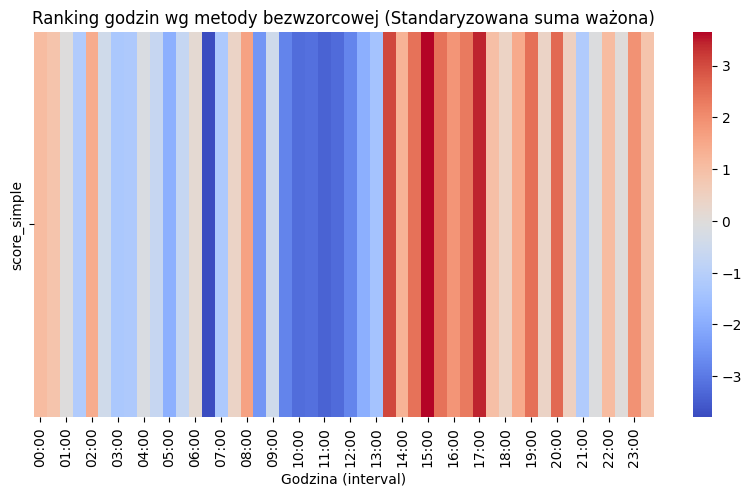

In [185]:
plot_heatmap(
    stats,
    column='score_simple',
    title='Ranking godzin wg metody bezwzorcowej (Standaryzowana suma ważona)'
)

## Metoda bezwzorcowa

W metodzie porządkowania liniowego ranking godzin opiera się na prostym zsumowaniu standaryzowanych wartości cech diagnostycznych.
Godziny o najwyższych wartościach cech stymulujących i najniższej zmienności uzyskały najwyższe wyniki.
Najlepsze przedziały godzinowe skupiają się wokół popołudnia, natomiast godziny poranne i nocne charakteryzują się niższymi ocenami.

In [186]:
# Większa waga dla zwrotu
weights = {
    'range_mean': 2.0,
    'volume_mean': 1.0,
    'atr_mean': 1.5,
    'abs_sharpe': 2.0,
    'return_std_stim': 1.0
}

# Oblicz ranking ważony
stats['score_weighted'] = sum(X_scaled[col] * w for col, w in weights.items())


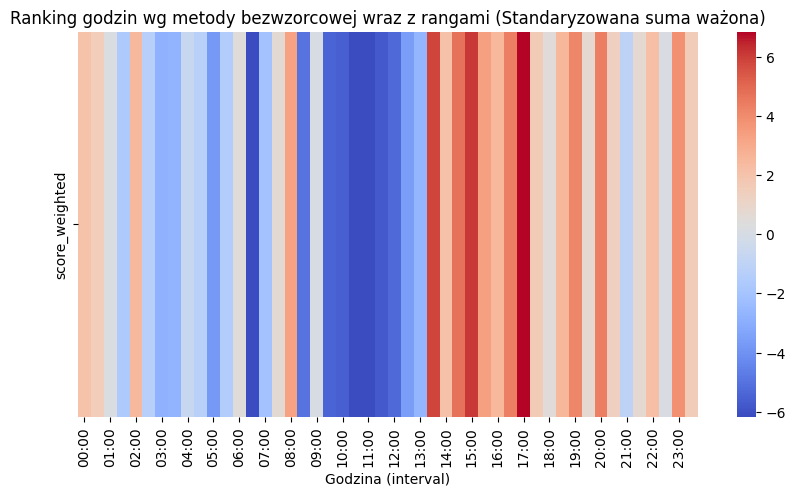

In [187]:
plot_heatmap(
    stats,
    column='score_weighted',
    title='Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma ważona)'
)

# Metoda bezwzorcowa z wagami

Po uwzględnieniu wag poszczególnych zmiennych ranking stał się bardziej zróżnicowany.
Wagi zwiększyły wpływ kluczowych czynników (np. stabilności lub wolumenu), przez co różnice między godzinami są bardziej wyraźne.
Najlepsze godziny pozostały zbliżone do poprzedniego zestawienia, lecz ich przewaga nad pozostałymi jest silniej zaznaczona.

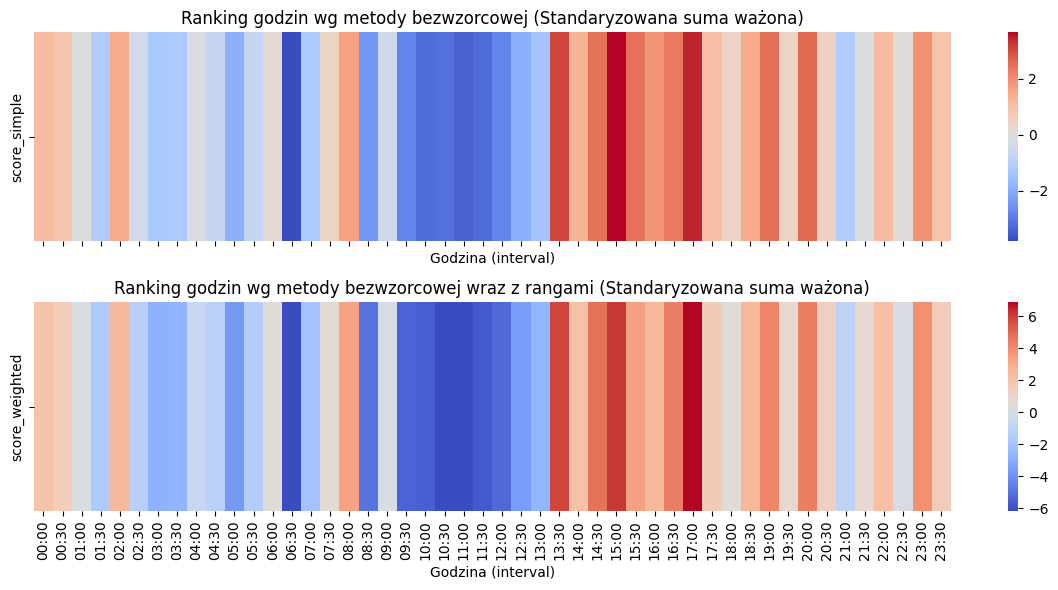

In [188]:
plot_heatmaps_stacked(
    stats,
    columns=['score_simple', 'score_weighted'],
    titles=[
        'Ranking godzin wg metody bezwzorcowej (Standaryzowana suma ważona)',
        'Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma ważona)'
    ],
    shared_scale=False
)

# Porównanie metod a) i b)

Obie metody wskazują podobny układ najlepszych i najsłabszych godzin, co potwierdza stabilność wniosków.
Zastosowanie wag nie zmieniło kierunku ocen, lecz wzmocniło kontrasty i lepiej oddało znaczenie poszczególnych czynników w kształtowaniu rankingu.

# Metoda wzorcowa



In [189]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Wybieram cechy diagnostyczne
features = ['range_mean', 'volume_mean', 'atr_mean', 'abs_sharpe', 'return_std_stim']

# ==========================================================
# 2️⃣ Normalizacja (0–1)
# ==========================================================

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(stats[features]),
    columns=features,
    index=stats.index
)

# ==========================================================
# 3️⃣ Wyznaczenie wzorca i antywzorca
# ==========================================================

# Wzorzec = maksymalne wartości
pattern = X_scaled.max()

# Antywzorzec = minimalne wartości
anti_pattern = X_scaled.min()

# ==========================================================
# 4️⃣ Odległości od wzorca i antywzorca
# ==========================================================

# Odległość euklidesowa od wzorca (im mniejsza tym lepiej)
stats['d_plus'] = np.sqrt(((X_scaled - pattern) ** 2).sum(axis=1))

# Odległość od antywzorca (im większa tym lepiej)
stats['d_minus'] = np.sqrt(((X_scaled - anti_pattern) ** 2).sum(axis=1))

# ==========================================================
# 5️⃣ Wskaźnik Hellwiga (miara bliskości do wzorca)
# ==========================================================

stats['score_hellwig'] = stats['d_minus'] / (stats['d_plus'] + stats['d_minus'])

# ==========================================================
# 6️⃣ Ranking godzin wg metody wzorcowej
# ==========================================================

ranking_hellwig = stats[['score_hellwig']].sort_values(by='score_hellwig', ascending=False)

print(ranking_hellwig.head(10))

          score_hellwig
interval               
17:00          0.601872
15:00          0.591018
20:00          0.558944
16:30          0.554736
19:00          0.552381
15:30          0.549132
13:30          0.547466
14:30          0.534792
16:00          0.525435
23:00          0.524377


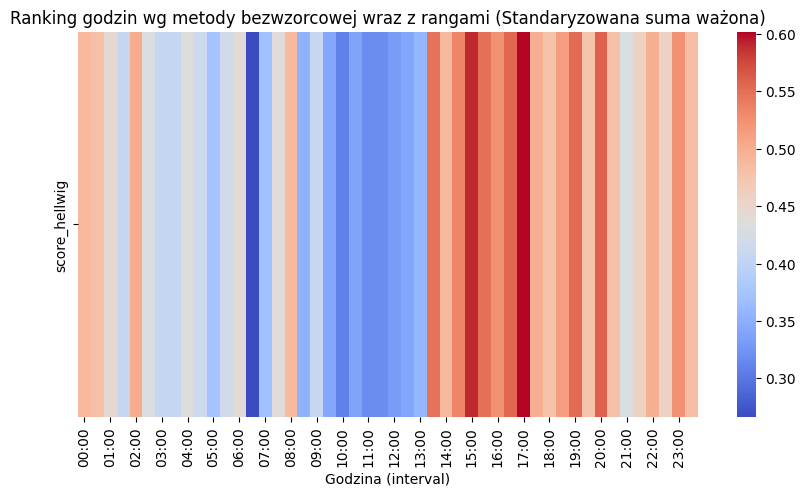

In [190]:
plot_heatmap(
    stats,
    column='score_hellwig',
    title='Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma ważona)'
)

# Metoda wzorcowa Hellwiga

Metoda Hellwiga ocenia każdą godzinę względem wzorca o najlepszych wartościach wszystkich cech.
Najwyższe wartości wskaźnika syntetycznego (blisko wzorca) uzyskały godziny z równowagą między wysokimi wynikami a niską zmiennością.
Ranking potwierdza przewagę godzin popołudniowych, jednak rozkład ocen jest bardziej wygładzony niż w metodach bezwzorcowych.

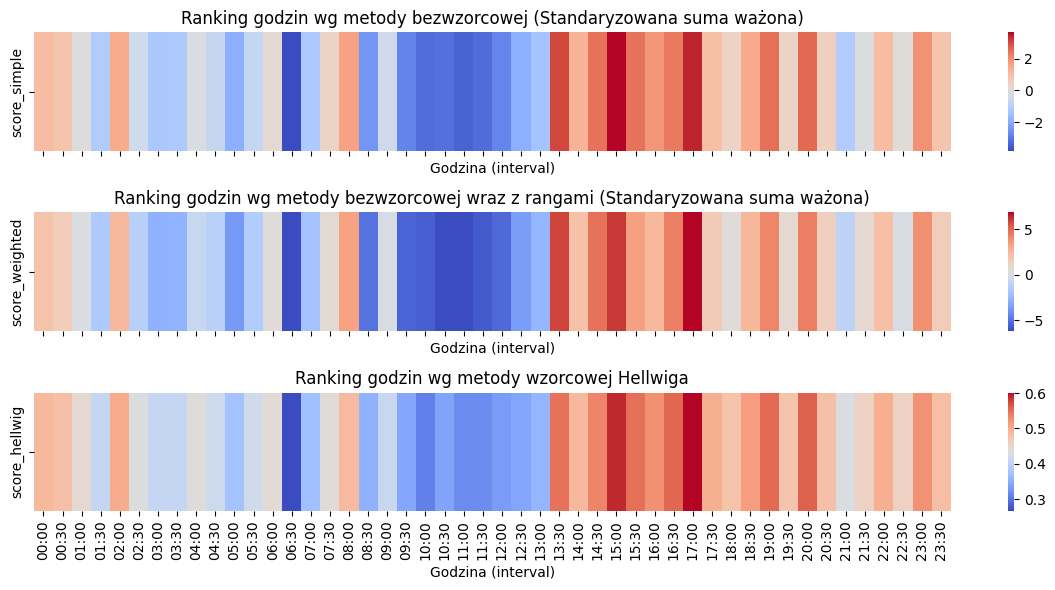

In [191]:
plot_heatmaps_stacked(
    stats,
    columns=['score_simple', 'score_weighted', 'score_hellwig'],
    titles=[
        'Ranking godzin wg metody bezwzorcowej (Standaryzowana suma ważona)',
        'Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma ważona)',
        'Ranking godzin wg metody wzorcowej Hellwiga'
    ],
    shared_scale=False
)

# Porównanie metod a), b) i d)

Wszystkie trzy metody wykazują spójny trend — najwyższe oceny przypadają na godziny popołudniowe, najniższe na poranne.
Metoda Hellwiga potwierdza wyniki porządkowania liniowego, ale uwzględnia relatywną odległość od wzorca, przez co jest bardziej odporna na skrajne wartości.
Zastosowanie wag w metodzie bezwzorcowej zwiększyło kontrast, natomiast metoda wzorcowa dała bardziej zrównoważony obraz rankingu.

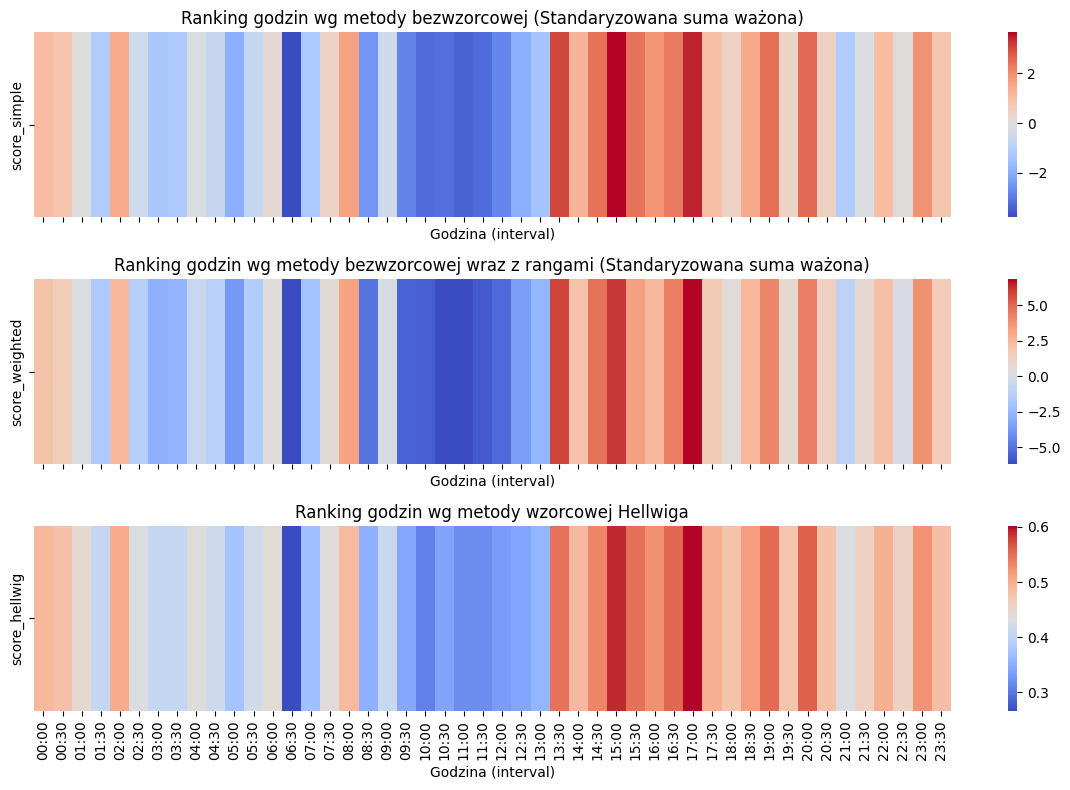

In [192]:
def plot_heatmaps(df, score_cols, titles, figsize=(12, 8)):
    n = len(score_cols)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    for i, (ax, col, title) in enumerate(zip(axes, score_cols, titles)):
        sns.heatmap(df[[col]].T, cmap='coolwarm', cbar=True, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Godzina (interval)')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()


plot_heatmaps(
    stats,
    score_cols=['score_simple', 'score_weighted', 'score_hellwig'],
    titles=[
        'Ranking godzin wg metody bezwzorcowej (Standaryzowana suma ważona)',
        'Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma ważona)',
        'Ranking godzin wg metody wzorcowej Hellwiga'
    ]
)

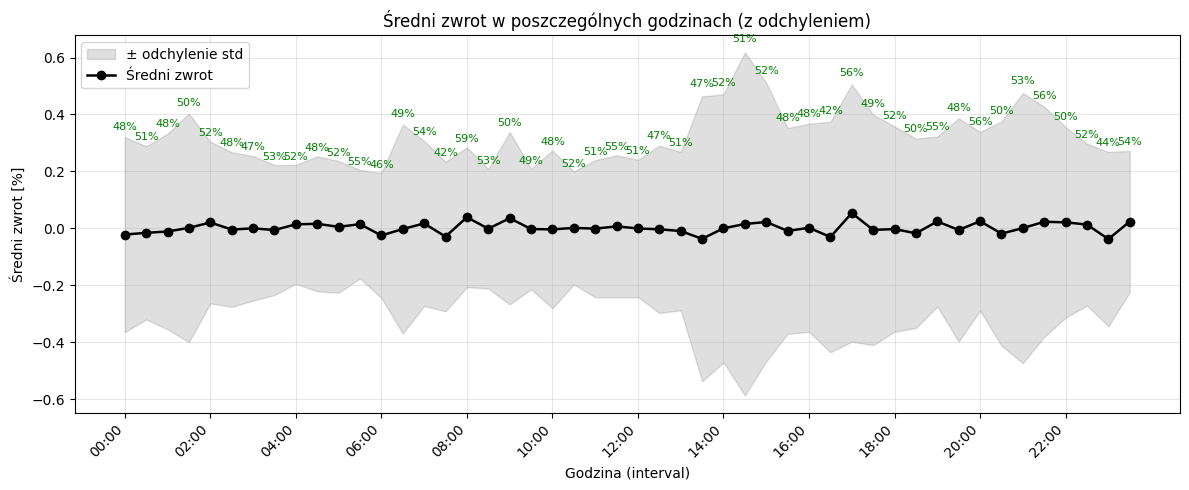

In [193]:
def plot_returns_detailed(df, return_mean_col='return_mean', return_std_col='return_std',
                          pos_ratio_col='pos_ratio', figsize=(12, 5)):
    """
    Wykres średnich zwrotów z odchyleniem standardowym i procentem dodatnich godzin.

    Parameters
    ----------
    df : pd.DataFrame
        Dane z kolumnami zwrotów, odchyleń i procentem dodatnich godzin.
    return_mean_col : str
        Kolumna ze średnim zwrotem [%].
    return_std_col : str
        Kolumna z odchyleniem standardowym [%].
    pos_ratio_col : str
        Kolumna z procentem dodatnich godzin.
    figsize : tuple
        Rozmiar figury.
    """

    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(df))
    hours = df.index

    mean = df[return_mean_col]
    std = df[return_std_col]

    # Szare tło ± odchylenie
    ax.fill_between(x, mean - std, mean + std, alpha=0.25, color='gray', label='± odchylenie std')

    # Czarna linia średnich zwrotów
    ax.plot(x, mean, color='black', marker='o', linewidth=1.8, label='Średni zwrot')

    # Czytelna oś X
    step = max(1, len(hours) // 12)
    ax.set_xticks(x[::step])
    ax.set_xticklabels(hours[::step], rotation=45, ha='right')

    # Opisy
    ax.set_title('Średni zwrot w poszczególnych godzinach (z odchyleniem)')
    ax.set_xlabel('Godzina (interval)')
    ax.set_ylabel('Średni zwrot [%]')
    ax.grid(alpha=0.3)
    ax.legend()

    # Dodanie informacji o procentach pozytywnych godzin
    if pos_ratio_col in df.columns:
        for i, (y, ratio) in enumerate(zip(mean, df[pos_ratio_col])):
            ax.text(i, y + std.iloc[i] * 1.05, f"{ratio:.0f}%", ha='center', va='bottom', fontsize=8, color='green')

    plt.tight_layout()
    plt.show()


plot_returns_detailed(stats)

### Średni zwrot (`czarna linia`)

Średnie zwroty w poszczególnych półgodzinach są **bliskie zera**, co sugeruje brak wyraźnej przewagi jednej pory dnia.
Różnice między godzinami są niewielkie, a te które występują nazwałbym szumem na niskim interwale.


### Zmienność (`szare pole – odchylenie std`)

Zakres szarego pola pokazuje, że **w większości godzin zmienność utrzymuje się na umiarkowanym poziomie (ok. ±0.3–0.5%)**.
Największe odchylenia widoczne są w godzinach **około 13:30–15:30** (pre market i otwarcie sesji amerykańskiej)


### Procent dodatnich przypadków (`zielone etykiety`)

Większość godzin ma **około 48–55% świec wzrostowych**, czyli rynkowo neutralny rozkład — brak silnej asymetrii.
Godziny z **wyższym udziałem pozytywnych zwrotów (55–59%)** mogą wskazywać na **czasową przewagę popytu** (np. po publikacjach lub sesjach USA).
Z kolei godziny **poniżej 45%** sugerują częstsze spadki i dominację podaży.


### Podsumowanie ogólne

* Rynek jest **w dużej mierze losowy intraday**, ale pewne godziny (szczególnie popołudniowe) oferują **więcej okazji** przy wyższym ryzyku.
* Brak wyraźnej przewagi w samych średnich zwrotach oznacza, że **sama pora dnia nie jest wystarczającym predyktorem kierunku**.

In [194]:
def group_by_mean(x):
    if x >= mean_val + std_val:
        return 'bardzo dobre'
    elif x >= mean_val:
        return 'dobre'
    elif x >= mean_val - std_val:
        return 'średnie'
    else:
        return 'słabe'

col = 'score_weighted'
mean_val = stats[col].mean()
std_val = stats[col].std()

stats['group_weighted'] = stats[col].apply(group_by_mean)

print(stats['group_weighted'])

interval
00:00           dobre
00:30           dobre
01:00           dobre
01:30         średnie
02:00           dobre
02:30         średnie
03:00         średnie
03:30         średnie
04:00         średnie
04:30         średnie
05:00           słabe
05:30         średnie
06:00           dobre
06:30           słabe
07:00         średnie
07:30           dobre
08:00           dobre
08:30           słabe
09:00           dobre
09:30           słabe
10:00           słabe
10:30           słabe
11:00           słabe
11:30           słabe
12:00           słabe
12:30           słabe
13:00         średnie
13:30    bardzo dobre
14:00           dobre
14:30    bardzo dobre
15:00    bardzo dobre
15:30           dobre
16:00           dobre
16:30    bardzo dobre
17:00    bardzo dobre
17:30           dobre
18:00           dobre
18:30           dobre
19:00    bardzo dobre
19:30           dobre
20:00    bardzo dobre
20:30           dobre
21:00         średnie
21:30           dobre
22:00           dobre
2

In [195]:
col = 'score_hellwig'
mean_val = stats[col].mean()
std_val = stats[col].std()

stats['group_hellwig'] = stats[col].apply(group_by_mean)

print(stats['group_hellwig'])

interval
00:00           dobre
00:30           dobre
01:00         średnie
01:30         średnie
02:00           dobre
02:30         średnie
03:00         średnie
03:30         średnie
04:00         średnie
04:30         średnie
05:00         średnie
05:30         średnie
06:00         średnie
06:30           słabe
07:00         średnie
07:30         średnie
08:00           dobre
08:30           słabe
09:00         średnie
09:30           słabe
10:00           słabe
10:30           słabe
11:00           słabe
11:30           słabe
12:00           słabe
12:30           słabe
13:00           słabe
13:30    bardzo dobre
14:00           dobre
14:30    bardzo dobre
15:00    bardzo dobre
15:30    bardzo dobre
16:00           dobre
16:30    bardzo dobre
17:00    bardzo dobre
17:30           dobre
18:00           dobre
18:30           dobre
19:00    bardzo dobre
19:30           dobre
20:00    bardzo dobre
20:30           dobre
21:00         średnie
21:30           dobre
22:00           dobre
2

### Interpretacja

Pogrupowanie wyników w porsty sposób na 4 grupy potiwerdza iż najabrdziej aktywne i potencjalnie najlepsze godziny do handlowania na giełdzie to są godziny popołudniowe w okolicy otwarcia Nowojorskiej sesji.

# Analiza skupień

Celem tej części jest zidentyfikowanie grup godzin (interwałów czasowych), które mają podobne właściwości rynkowe np. podobną zmienność, aktywność itp.
W przeciwieństwie do metod porządkowania (które tworzą ranking liniowy), analiza skupień nie porządkuje, tylko grupuje obserwacje na podstawie ich podobieństwa.

Do przeprowadzenia grupowania wybrałem następujacy podzbiór zmiennych

| Zmienna       | Co mierzy                  |
| ------------- | -------------------------- |
| `range_mean`  | zmienność surowa           |
| `volume_mean` | aktywność rynku            |
| `atr_mean`    | wygładzona zmienność       |
| `abs_sharpe`  | kierunkowość ruchu         |
| `return_std`  | chaos / losowość           |
| `return_mean` | średni zwrot / kierunek    |
| `skewness`  	| skośność rozkładu zwrotów  |
| `kurtosis`  	| „grubość ogonów” rozkładu  |

In [196]:
features = [
    'range_mean',
    'volume_mean',
    'atr_mean',
    'abs_sharpe',
    'return_std',
    'return_mean',
    'skewness',
    'kurtosis',
]

# print(stats.head(5))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stats[features])

# Na potrzeby analizy utwórz DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=stats.index)

## Określenie optymalnej liczby skupień (k)

- metoda łokcia (Elbow Method), obserwujemy spadek sumy kwadratów błędów.
- metoda silhouette, mierzy jakość skupień (im wyższy współczynnik, tym lepszy podział).

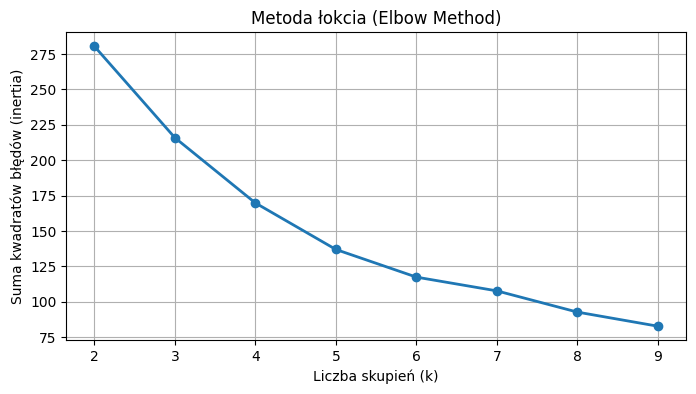

In [197]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(X_scaled_df)
    inertia.append(model.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.title('Metoda łokcia (Elbow Method)')
plt.xlabel('Liczba skupień (k)')
plt.ylabel('Suma kwadratów błędów (inertia)')
plt.grid(True)
plt.show()


#### Metoda łokcia (Elbow Method)
Na wykresie obserwujemy typowy spadek wartości sumy kwadratów błędów wraz ze wzrostem liczby skupień (k).
Dla małych wartości k spadek jest gwałtowny, co oznacza, że dodanie kolejnych klastrów znacząco poprawia dopasowanie modelu.
Jednak od pewnego momentu tempo spadku wyraźnie maleje i tworzy się tzw. łokieć.

Wykres sugeruje, że podział danych na 4/5 skupienia zapewnia dobry kompromis między prostotą modelu a jakością dopasowania.


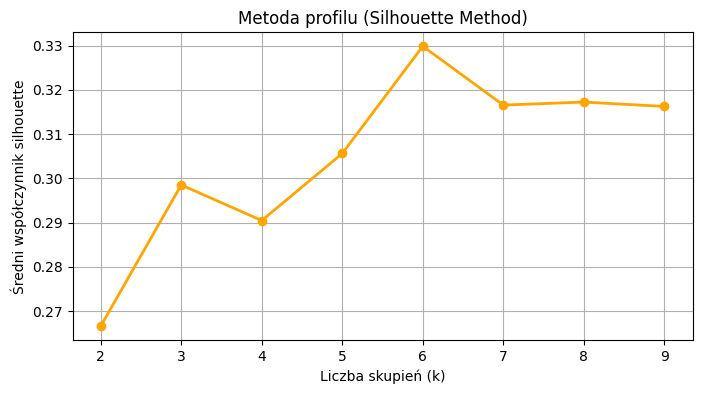

In [198]:
from sklearn.metrics import silhouette_score

silhouette = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled_df)
    score = silhouette_score(X_scaled_df, labels)
    silhouette.append(score)

plt.figure(figsize=(8,4))
plt.plot(K, silhouette, 'o-', linewidth=2, color='orange')
plt.title('Metoda profilu (Silhouette Method)')
plt.xlabel('Liczba skupień (k)')
plt.ylabel('Średni współczynnik silhouette')
plt.grid(True)
plt.show()


#### 

W metodzie silhouette oceniamy jakość rozdzielenia skupień, im wyższy współczynnik silhouette, tym lepiej dane są pogrupowane (wartości bliskie 1 oznaczają dobrze odseparowane klastry).

Na wykresie widać, że współczynnik silhouette osiąga najwyższą wartość przy k = 6, co wskazuje, że w tym punkcie uzyskano najbardziej spójne i najlepiej odseparowane skupienia.
Dla mniejszych wartości k (np. 2–4) widoczne jest słabsze dopasowanie, a powyżej 6 dalsze zwiększanie liczby klastrów nie przynosi już poprawy jakości.

In [199]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Liczba skupień
k = 5

# Tworzenie modelu
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
stats['cluster_kmeans'] = kmeans.fit_predict(X_scaled_df)

# Centroidy
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X_scaled_df.columns
)
centroids.index = [f'Cluster {i+1}' for i in range(k)]

In [200]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(
#     centroids,
#     cmap='coolwarm',
#     annot=True,
#     fmt=".2f",
#     cbar=True
# )
# plt.title('Profil cech w klastrach (metoda K-Means, k=6)')
# plt.xlabel('Zmienna diagnostyczna')
# plt.ylabel('Klaster')
# plt.tight_layout()
# plt.show()

Ta mapa pozwala zobaczyć, które cechy dominują w poszczególnych grupach — np. które godziny mają najwyższą zmienność, największy wolumen, najwyższy Sharpe itp.

In [204]:
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_pca_clusters(stats, X_scaled_df, cluster_col='cluster_kmeans', k=5,
                      figsize=(8, 6), palette_name='tab10', title=None):
    """
    Wizualizuje skupienia w przestrzeni PCA (2D).

    Zwraca słownik {id_klastra: kolor}, by zachować spójność kolorów z heatmapą.
    """
    # PCA redukcja
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled_df)
    stats['PCA1'] = pca_result[:, 0]
    stats['PCA2'] = pca_result[:, 1]

    # Kolory
    palette = sns.color_palette(palette_name, k)
    cluster_colors = {i: palette[i] for i in range(k)}

    # Wykres
    plt.figure(figsize=figsize)
    for i in range(k):
        cluster_data = stats[stats[cluster_col] == i]
        color = cluster_colors[i]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'],
                    s=60, color=color, label=f'Cluster {i+1}', alpha=0.7)

    plt.title(title or f'Wizualizacja skupień (PCA, {cluster_col.replace("cluster_", "").upper()}, k={k})')
    plt.xlabel(f'Wymiar 1 ({pca.explained_variance_ratio_[0]*100:.1f}% zmienności)')
    plt.ylabel(f'Wymiar 2 ({pca.explained_variance_ratio_[1]*100:.1f}% zmienności)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return cluster_colors

from matplotlib.patches import Rectangle
def plot_cluster_heatmap(stats, cluster_col='cluster_kmeans', cluster_colors=None, figsize=(12, 1.5)):
    """
    Estetyczna wizualizacja przynależności godzin do klastrów (jedna linia kolorów).
    Kolory są zgodne z paletą z PCA.
    """
    if cluster_colors is None:
        unique_clusters = stats[cluster_col].unique()
        palette = sns.color_palette('tab10', len(unique_clusters))
        cluster_colors = {c: palette[i] for i, c in enumerate(unique_clusters)}

    # Przygotowanie danych
    colors = stats[cluster_col].map(cluster_colors)
    intervals = stats.index.tolist()

    fig, ax = plt.subplots(figsize=figsize)

    # Rysujemy prostokąty – każdy kolor to jedna godzina
    for i, color in enumerate(colors):
        ax.add_patch(Rectangle((i, 0), 1, 1, color=color))

    # Oś X = godziny
    ax.set_xlim(0, len(intervals))
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(intervals)))
    ax.set_xticklabels(intervals, rotation=90)
    ax.set_yticks([])

    ax.set_title('Przynależność godzin do klastrów (K-Means)', fontsize=12, pad=10)
    ax.set_xlabel('Godzina (interval)')

    plt.tight_layout()
    plt.show()


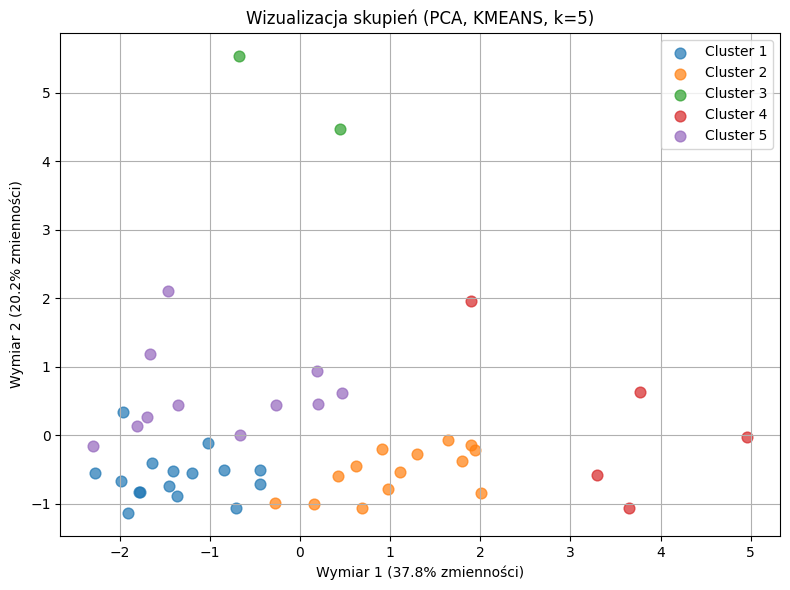

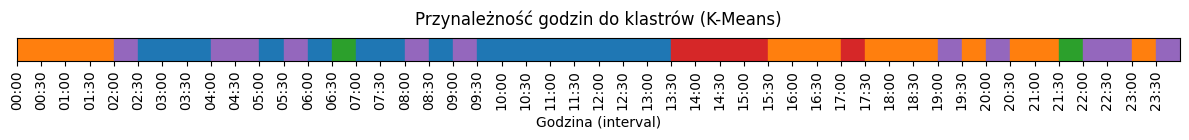

In [205]:
# 1️⃣ Rysujemy PCA i zapamiętujemy kolory
cluster_colors = plot_pca_clusters(stats, X_scaled_df, cluster_col='cluster_kmeans', k=k)

# 2️⃣ Rysujemy heatmapę z tymi samymi kolorami
plot_cluster_heatmap(stats, cluster_col='cluster_kmeans', cluster_colors=cluster_colors)


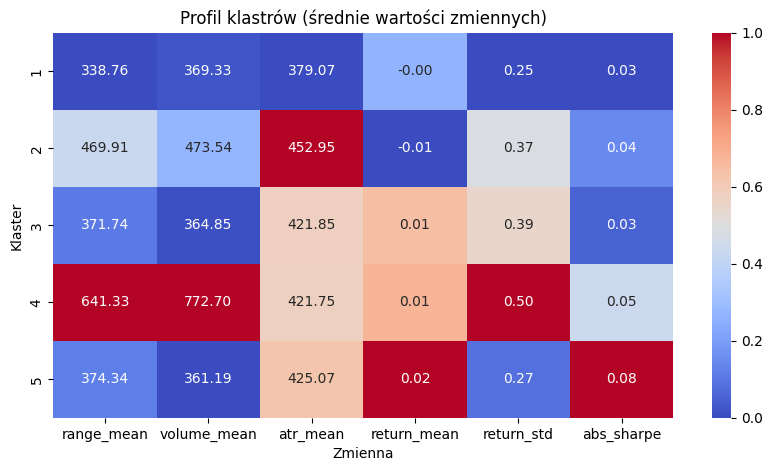

In [206]:
# 🔹 Wybieramy tylko kolumny numeryczne, które mają sens dla interpretacji
feature_cols = [
    'range_mean', 'volume_mean', 'atr_mean', 
    'return_mean', 'return_std', 'abs_sharpe'
]

# 🔹 Grupujemy po klastrach i liczymy średnie wartości
cluster_profile = stats.groupby('cluster_kmeans')[feature_cols].mean().round(3)

# 🔹 Normalizujemy (żeby móc porównać różne skale)
cluster_profile_norm = cluster_profile.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 🔹 Heatmapa profili klastrów
plt.figure(figsize=(10, 5))
ax = sns.heatmap(cluster_profile_norm, annot=cluster_profile, cmap='coolwarm', fmt='.2f')

# ✅ Ustawiamy etykiety osi Y, żeby zamiast 0–4 wyświetlało 1–5
ax.set_yticklabels([str(i+1) for i in cluster_profile.index])

plt.title('Profil klastrów (średnie wartości zmiennych)')
plt.xlabel('Zmienna')
plt.ylabel('Klaster')
plt.show()

## Interpretacja klastrów (k = 5, metoda K-Means)

### Klaster 1 — Godziny spokojne, niska zmienność i aktywność

* **range_mean, volume_mean, atr_mean:** najniższe w zestawieniu
* **return_std:** najniższe (0.25), bardzo małe wahania
* **return_mean:** bliskie zera (-0.003), brak wyraźnego trendu
* **abs_sharpe:** niskie (0.029)
  Godziny neutralne, mało interesujące z punktu widzenia handlu, rynek praktycznie stoi.

### Klaster 2 — Godziny o wysokiej zmienności i dużych wolumenach, ale bez wyraźnego kierunku

* **range_mean, volume_mean, atr_mean:** wysokie
* **return_std:** duże (0.37)
* **return_mean:** lekko ujemne (-0.012)
* **abs_sharpe:** niskie (0.037)
  Intensywne godziny z dużym wolumenem i ruchem, ale pozbawione kierunku, sygnały bywają chaotyczne. Typowe dla otwarcia sesji lub danych makro o dużej zmienności.

### Klaster 3 — Umiarkowanie aktywny rynek z lekką zmiennością i wzrostami

* **range_mean, atr_mean:** średnie
* **return_mean:** dodatnie (0.010)
* **return_std:** umiarkowane (0.39)
* **abs_sharpe:** przeciętne (0.032)
  Godziny zrównoważone, ruchy są widoczne, ale ryzyko umiarkowane. Często występuje lekka przewaga kupujących.

### Klaster 4 — Aktywne godziny o największym wolumenie i zmienności

* **range_mean:** ekstremalnie wysokie (641)
* **volume_mean:** bardzo duże (773)
* **return_std:** najwyższe (0.50)
* **return_mean:** dodatnie (0.011)
* **abs_sharpe:** solidne (0.053)
  Typowe godziny dużych ruchów, okresy nakładających się sesji (np. Londyn–Nowy Jork). Dla traderów: potencjał, ale też duże ryzyko.

### Klaster 5 — Godziny stabilne, ale z najlepszym stosunkiem zysku do ryzyka

* **return_mean:** najwyższe (0.022)
* **return_std:** stosunkowo niskie (0.27)
* **abs_sharpe:** najwyższe (0.084)
  Godziny najbardziej sprzyjające handlowi, niska zmienność, dodatnie zwroty i wysoka efektywność (Sharpe). Prawdopodobnie odpowiadają spokojnym trendom lub godzinom o przewidywalnych ruchach.

## Podsumowanie klastrów

| Klaster | Charakterystyka                    | Wnioski dla strategii                      |
| :------ | :--------------------------------- | :----------------------------------------- |
| 1       | Spokojny, niska aktywność          | Unikać, brak ruchu                         |
| 2       | Wysoka zmienność, chaos            | Ryzykowny, duże wybicia bez kierunku       |
| 3       | Umiarkowany wzrost i zmienność     | Stabilny handel, lekko pozytywne tendencje |
| 4       | Największa zmienność, duży wolumen | Główna aktywność sesyjna                   |
| 5       | Najlepszy stosunek zysku do ryzyka | Najkorzystniejsze godziny handlowe         |


## Podsumowanie metody K-Means

Metoda K-Means pozwoliła na wyodrębnienie pięciu wyraźnie różniących się klastrów godzin handlu. Każdy klaster charakteryzuje się odmiennym poziomem zmienności, wolumenu i relacji zysku do ryzyka. Najbardziej efektywne godziny (klaster 4) wyróżniają się dodatnimi zwrotami przy niskim ryzyku, natomiast klaster 3 obejmuje okresy największej aktywności i zmienności. Klastery 0 i 1 reprezentują godziny spokojne lub chaotyczne, o niskiej jakości sygnałów rynkowych. K-Means dobrze odwzorowuje strukturalne różnice między zachowaniem rynku w poszczególnych porach dnia, co stanowi solidną podstawę do porównania z metodami hierarchicznymi.

## Metoda hierarchiczna Warda



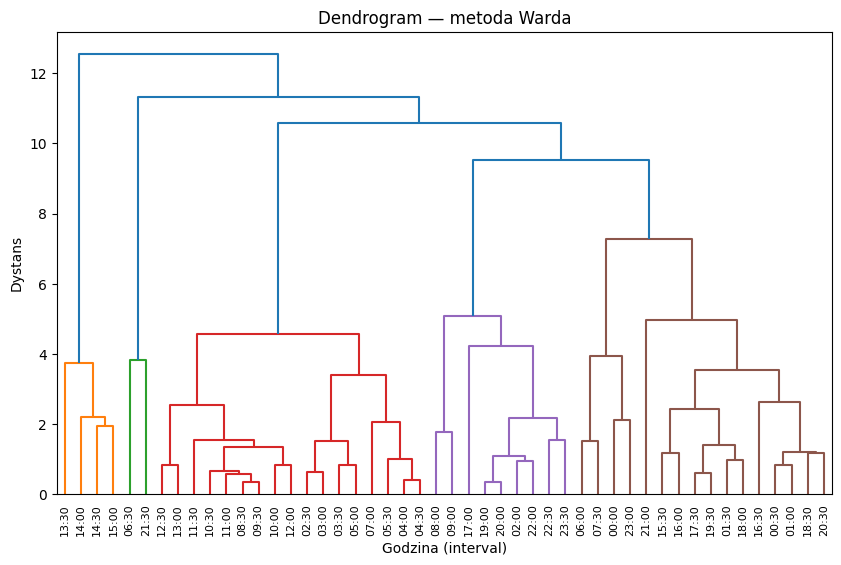

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Używamy tych samych danych co wcześniej (X_scaled_df)
Z = linkage(X_scaled_df, method='ward')

# 🔹 Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=stats.index, leaf_rotation=90)
plt.title('Dendrogram — metoda Warda')
plt.xlabel('Godzina (interval)')
plt.ylabel('Dystans')
plt.show()

# 🔹 Wybieramy 5 klastrów (dla porównania z K-Means)
k = 5
stats['cluster_ward'] = fcluster(Z, k, criterion='maxclust') - 1  # etykiety od 0 do 4


## Interpretacja dendrogramu

- Oś pionowa (Dystans) pokazuje, jak bardzo różnią się od siebie łączone grupy. Im wyżej następuje połączenie, tym większa różnica między klastrami.

- Kolorowe gałęzie oznaczają pięć wyodrębnionych skupień (k=5). Granicę podziału wyznacza pozioma linia.

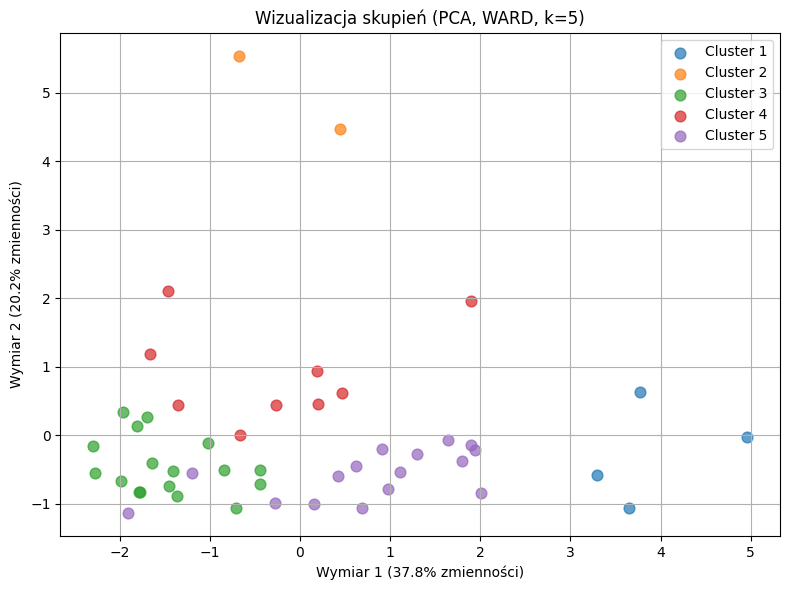

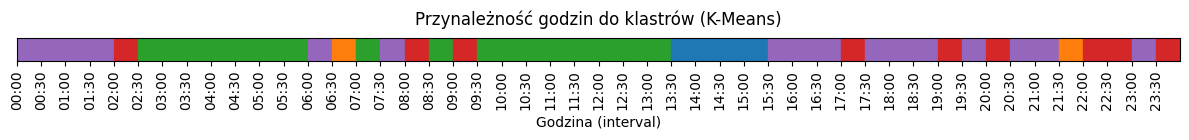

In [216]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(X_scaled_df)
# stats['PCA1'] = pca_result[:, 0]
# stats['PCA2'] = pca_result[:, 1]

# plt.figure(figsize=(8, 6))
# colors = sns.color_palette('tab10', k)

# for i in range(1, k+1):
#     cluster_data = stats[stats['cluster_ward'] == i]
#     plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'],
#                 s=60, color=colors[i-1], label=f'Cluster {i}', alpha=0.7)

# plt.title('Wizualizacja skupień (PCA, metoda Warda, k=5)')
# plt.xlabel(f'Wymiar 1 ({pca.explained_variance_ratio_[0]*100:.1f}% zmienności)')
# plt.ylabel(f'Wymiar 2 ({pca.explained_variance_ratio_[1]*100:.1f}% zmienności)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# pd.crosstab(stats['cluster_kmeans'], stats['cluster_ward'])



cluster_colors = plot_pca_clusters(stats, X_scaled_df, cluster_col='cluster_ward', k=5)
plot_cluster_heatmap(stats, cluster_col='cluster_ward', cluster_colors=cluster_colors)


## Interpretacja wizualizacji PCA

Drugi wykres przedstawia te same dane po redukcji wymiarów metodą PCA, czyli odwzorowanie wielowymiarowych cech (zmienność, wolumen, zwroty itp.) na dwie osie, które wyjaśniają łącznie ok. 58% wariancji (37.8% + 20.2%).

Widać wyraźnie, że:
- Klaster 4 zajmuje pozycję skrajną, to najbardziej aktywne godziny z dużą zmiennością i wolumenem.
- Klaster 2 zawiera kilka punktów oddalonych — prawdopodobnie rzadkie, nietypowe godziny (np. sesje o anomaliach).
- Klastry 3 i 5 tworzą bardziej zwarte grupy, oznaczające stabilne okresy o podobnych charakterystykach.
- Klastry 3, 4, 5 znajdują się dość blisko siebie, czyli potencjalnie przy mniejszym k (np k=3) mogły by tworzyć podobną jedną grupę

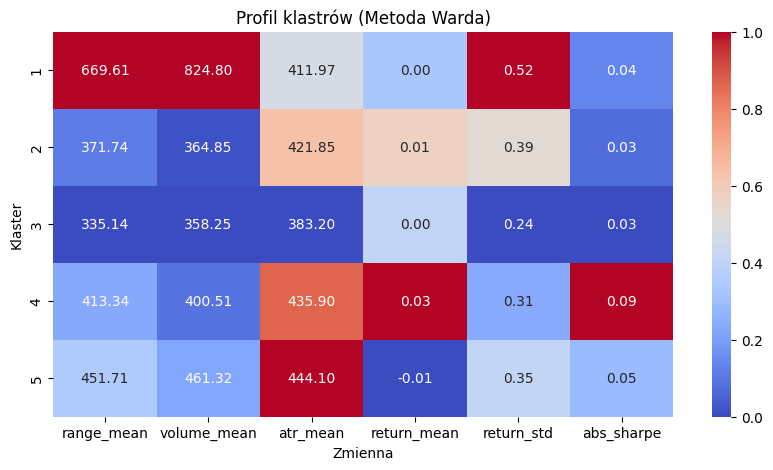

In [218]:
feature_cols = [
    'range_mean', 'volume_mean', 'atr_mean', 
    'return_mean', 'return_std', 'abs_sharpe'
]

cluster_profile_ward = stats.groupby('cluster_ward')[feature_cols].mean().round(3)
cluster_profile_ward_norm = cluster_profile_ward.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(10, 5))
ax = sns.heatmap(cluster_profile_ward_norm, annot=cluster_profile_ward, cmap='coolwarm', fmt='.2f')
ax.set_yticklabels([str(i + 1) for i in cluster_profile_ward.index])
plt.title('Profil klastrów (Metoda Warda)')
plt.xlabel('Zmienna')
plt.ylabel('Klaster')
plt.show()

## Interpretacja klastrów (k = 5, metoda Warda)

### Klaster 1 — Godziny największej aktywności i zmienności

* **range_mean, volume_mean:** najwyższe (670, 825)
* **atr_mean:** nieco niższy (412)
* **return_std:** najwyższe (0.52)
* **return_mean:** ≈ 0, brak wyraźnego kierunku
* **abs_sharpe:** umiarkowane (0.036)

To okresy o największym ruchu i wolumenie — typowo nakładające się sesje (np. Londyn–Nowy Jork).
Rynek jest bardzo aktywny, ale bez wyraźnego trendu — dominują dynamiczne, często chaotyczne ruchy.

### Klaster 2 — Umiarkowanie zmienne godziny z lekką przewagą wzrostów

* **range_mean, volume_mean:** średnie
* **atr_mean:** umiarkowany (422)
* **return_mean:** dodatni (0.01)
* **return_std:** wyższe (0.39)
* **abs_sharpe:** średnie (0.032)

Okresy stabilne z lekkim ruchem wzrostowym.
Rynek umiarkowanie aktywny, bez gwałtownych skoków — dobry balans między ryzykiem a zmiennością.

### Klaster 3 — Godziny spokojne, niska aktywność i zmienność

* **range_mean, volume_mean, atr_mean:** najniższe (335–383)
* **return_mean:** bliskie zera (0.003)
* **return_std:** najmniejsze (0.24)
* **abs_sharpe:** najniższe (0.027)

Typowe „martwe godziny” z niskim wolumenem i minimalną zmiennością.
Rynek w stanie konsolidacji lub braku aktywności – brak okazji handlowych.

### Klaster 4 — Godziny stabilne, ale z dodatnim kierunkiem

* **range_mean, volume_mean:** umiarkowane (413–401)
* **atr_mean:** najwyższy (436)
* **return_mean:** najwyższy (0.028)
* **return_std:** średni (0.31)
* **abs_sharpe:** najwyższy (0.093)

Okresy najbardziej zyskowne przy rozsądnym ryzyku.
Dobre godziny do handlu trendowego – rynek wykazuje przewagę w kierunku wzrostowym i dobrą relację zysku do ryzyka.

### Klaster 5 — Aktywne, ale spadkowe godziny

* **range_mean, volume_mean:** nieco powyżej średniej (452–461)
* **atr_mean:** wysoki (444)
* **return_mean:** ujemny (-0.014)
* **return_std:** umiarkowany (0.35)
* **abs_sharpe:** umiarkowany (0.046)

Godziny o zwiększonej aktywności i wyraźnej tendencji spadkowej.
Mogą wskazywać na momenty realizacji zysków lub silniejsze korekty po okresach wzrostu.

---

## Podsumowanie klastrów

| Klaster | Charakterystyka                     | Wnioski dla strategii                     |
| :------ | :---------------------------------- | :---------------------------------------- |
| 1       | Największa zmienność, duży wolumen  | Główne sesje, duże ryzyko i potencjał     |
| 2       | Umiarkowane wzrosty, stabilny rynek | Dobry balans zysku i ryzyka               |
| 3       | Spokojny, mało aktywny              | Brak ruchu, unikać handlu                 |
| 4       | Najlepszy stosunek zysku do ryzyka  | Korzystne godziny do strategii trendowych |
| 5       | Aktywne, ale spadkowe               | Potencjalne momenty korekcyjne lub shorty |

# Podsumowanie Analizy Skupień

Obie metody dały bardzo zbiżone wyniki i na 48 obiektów do klasteryzacji, różnią się tylko ok. 5 dopasowaniami ( w rejonach 04:00-08:00 ).
W celu potwierdzenia, że klastry są podobne zbadamy to używając
- Adjusted Rand Index (ARI) - mierzy, jak bardzo dwa podziały danych są do siebie podobne, porównuje wszystkie pary obserwacji i sprawdza, czy w obu metodach trafiły do tego samego klastra. Wartość 1 oznacza idealne dopasowanie, 0 losowe przypisanie.
- Normalized Mutual Information (NMI) - ocenia, ile informacji o jednym grupowaniu można uzyskać, znając drugie, im bliżej 1, tym bardziej jedno grupowanie „tłumaczy” drugie.

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(stats['cluster_kmeans'], stats['cluster_ward'])
nmi = normalized_mutual_info_score(stats['cluster_kmeans'], stats['cluster_ward'])

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

Adjusted Rand Index (ARI): 0.688
Normalized Mutual Information (NMI): 0.763


Uzyskaliśmy bardzo wysokie wartości, co pokazują, że klastry pokrywają się merytorycznie.

ARI = 0.688 to silne podobieństwo struktury klastrów (bliskie 0.7)
NMI = 0.763 to ponad 75% wspólnej informacji między podziałami

Czyli obie metody dały bardzo podobne grupy.